# Predicting Dengue Code

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# for making the report cleaner
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# getting the data
filepath = 'data/'
dengue_train_features = pd.read_csv(filepath + 'dengue_features_train.csv')
dengue_test_features = pd.read_csv(filepath + 'dengue_features_test.csv')
dengue_train_labels = pd.read_csv(filepath + 'dengue_labels_train.csv')
dengue_train_features['total_cases'] = dengue_train_labels.total_cases

In [3]:
# number of null values per column
print('NA values for train')
dengue_train_features.isna().sum()

NA values for train


city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [4]:
# number of null values per column
print('NA values for test')
dengue_test_features.isna().sum()

NA values for test


city                                      0
year                                      0
weekofyear                                0
week_start_date                           0
ndvi_ne                                  43
ndvi_nw                                  11
ndvi_se                                   1
ndvi_sw                                   1
precipitation_amt_mm                      2
reanalysis_air_temp_k                     2
reanalysis_avg_temp_k                     2
reanalysis_dew_point_temp_k               2
reanalysis_max_air_temp_k                 2
reanalysis_min_air_temp_k                 2
reanalysis_precip_amt_kg_per_m2           2
reanalysis_relative_humidity_percent      2
reanalysis_sat_precip_amt_mm              2
reanalysis_specific_humidity_g_per_kg     2
reanalysis_tdtr_k                         2
station_avg_temp_c                       12
station_diur_temp_rng_c                  12
station_max_temp_c                        3
station_min_temp_c              

In [5]:
# converts to celsius
def kelvin_to_c(temperature):
    return temperature - 273.15

# converts values of columns to celsius
def column_to_celsius(df, column_name):
    column_celsius = column_name[:-1] + "c"
    df[column_celsius] = df[column_name].apply(lambda x: kelvin_to_c(x))
        
# replcae na values of column1 with column2
def impute_from_column(df, column1, column2):
    print(column1 + " na values before:", df[column1].isna().sum())
    df[column1] = df[column1].fillna(df[column2])
    print(column1 + " na values after:", df[column1].isna().sum())

In [6]:
# converting to celsius
column_to_celsius(dengue_train_features, 'reanalysis_avg_temp_k')
column_to_celsius(dengue_train_features, 'reanalysis_max_air_temp_k')
column_to_celsius(dengue_train_features, 'reanalysis_min_air_temp_k')
column_to_celsius(dengue_train_features, 'reanalysis_tdtr_k')
column_to_celsius(dengue_test_features, 'reanalysis_avg_temp_k')
column_to_celsius(dengue_test_features, 'reanalysis_max_air_temp_k')
column_to_celsius(dengue_test_features, 'reanalysis_min_air_temp_k')
column_to_celsius(dengue_test_features, 'reanalysis_tdtr_k')

In [7]:
# imputing for dengue train
reanalysis_c = ['reanalysis_avg_temp_c',
                'reanalysis_max_air_temp_c',
                'reanalysis_min_air_temp_c',
                'reanalysis_tdtr_c']

impute_from_column(dengue_train_features, 'station_avg_temp_c', 'reanalysis_avg_temp_c')
impute_from_column(dengue_train_features, 'station_diur_temp_rng_c', 'reanalysis_tdtr_k')
impute_from_column(dengue_train_features, 'station_max_temp_c', 'reanalysis_max_air_temp_c')
impute_from_column(dengue_train_features, 'station_min_temp_c', 'reanalysis_min_air_temp_c')
dengue_train_features = dengue_train_features.drop(columns=reanalysis_c, axis=1)

impute_from_column(dengue_test_features, 'station_avg_temp_c', 'reanalysis_avg_temp_c')
impute_from_column(dengue_test_features, 'station_diur_temp_rng_c', 'reanalysis_tdtr_k')
impute_from_column(dengue_test_features, 'station_max_temp_c', 'reanalysis_max_air_temp_c')
impute_from_column(dengue_test_features, 'station_min_temp_c', 'reanalysis_min_air_temp_c')
dengue_test_features = dengue_test_features.drop(columns=reanalysis_c, axis=1)

station_avg_temp_c na values before: 43
station_avg_temp_c na values after: 10
station_diur_temp_rng_c na values before: 43
station_diur_temp_rng_c na values after: 10
station_max_temp_c na values before: 20
station_max_temp_c na values after: 10
station_min_temp_c na values before: 14
station_min_temp_c na values after: 10
station_avg_temp_c na values before: 12
station_avg_temp_c na values after: 2
station_diur_temp_rng_c na values before: 12
station_diur_temp_rng_c na values after: 2
station_max_temp_c na values before: 3
station_max_temp_c na values after: 2
station_min_temp_c na values before: 9
station_min_temp_c na values after: 2


In [8]:
# forward filling data
dengue_train_features.fillna(method='ffill', inplace=True)
dengue_test_features.fillna(method='ffill', inplace=True)

In [9]:
# dropping column with too many missing values and week start date
dengue_train_features = dengue_train_features.drop(['ndvi_ne', 'week_start_date', 'precipitation_amt_mm'], axis=1)
dengue_test_features = dengue_test_features.drop(['ndvi_ne', 'week_start_date', 'precipitation_amt_mm'], axis=1)

In [10]:
# creating new features of interest
dengue_train_features['temp_r'] = 100 /  dengue_train_features['station_diur_temp_rng_c']
dengue_test_features['temp_r'] = 100 /  dengue_test_features['station_diur_temp_rng_c']
dengue_train_features['temp_optim'] = 100 /  abs(302.151 - dengue_train_features['reanalysis_avg_temp_k'])
dengue_test_features['temp_optim'] = 100 / abs(302.151 - dengue_train_features['reanalysis_avg_temp_k'])
dengue_train_features['air_dew'] = 100 /  abs(dengue_train_features['reanalysis_dew_point_temp_k'] - dengue_train_features['reanalysis_air_temp_k'])
dengue_test_features['air_dew'] = 100 /  abs(dengue_test_features['reanalysis_dew_point_temp_k'] - dengue_test_features['reanalysis_air_temp_k'])

In [11]:
# seperating train features by city
sj_train_features = dengue_train_features[dengue_train_features['city']=='sj']
iq_train_features = dengue_train_features[dengue_train_features['city']=='iq']

# seperating train labels by city
sj_train_labels = dengue_train_labels[dengue_train_labels['city']=='sj']
iq_train_labels = dengue_train_labels[dengue_train_labels['city']=='iq']

# serperating test features by city
sj_test_features = dengue_test_features[dengue_test_features['city']=='sj']
iq_test_features = dengue_test_features[dengue_test_features['city']=='iq']

In [12]:
sj_case_mean = sj_train_features.groupby(['weekofyear']).total_cases.mean().reset_index().set_index('weekofyear')
sj_case_mean.columns = ['case']
iq_case_mean = iq_train_features.groupby(['weekofyear']).total_cases.mean().reset_index().set_index('weekofyear')
iq_case_mean.columns = ['case']

In [13]:
sj_train_features = sj_train_features.join(sj_case_mean, on='weekofyear', rsuffix='_mean')
iq_train_features = iq_train_features.join(iq_case_mean, on='weekofyear', rsuffix='_mean')
                       
sj_test_features = sj_test_features.join(sj_case_mean, on='weekofyear', rsuffix='_mean')
iq_test_features = iq_test_features.join(iq_case_mean, on='weekofyear', rsuffix='_mean')

In [14]:
# # shifting back by 4 weeks
# sj_train_features.total_cases = sj_train_features.total_cases.shift(-4)
# iq_train_features.total_cases = iq_train_features.total_cases.shift(-4)

# # dropping the last row after the shift
# sj_train_features = sj_train_features[:-4]
# iq_train_features = iq_train_features[:-4]

In [15]:
sj_train_features.isna().sum()

city                                     0
year                                     0
weekofyear                               0
ndvi_nw                                  0
ndvi_se                                  0
ndvi_sw                                  0
reanalysis_air_temp_k                    0
reanalysis_avg_temp_k                    0
reanalysis_dew_point_temp_k              0
reanalysis_max_air_temp_k                0
reanalysis_min_air_temp_k                0
reanalysis_precip_amt_kg_per_m2          0
reanalysis_relative_humidity_percent     0
reanalysis_sat_precip_amt_mm             0
reanalysis_specific_humidity_g_per_kg    0
reanalysis_tdtr_k                        0
station_avg_temp_c                       0
station_diur_temp_rng_c                  0
station_max_temp_c                       0
station_min_temp_c                       0
station_precip_mm                        0
total_cases                              0
temp_r                                   0
temp_optim 

In [24]:
# dropping the city columns
sj_train_features = sj_train_features.drop('city', axis=1)
iq_train_features = iq_train_features.drop('city', axis=1)

sj_train_labels = sj_train_labels.drop('city', axis=1)
iq_train_labels = iq_train_labels.drop('city', axis=1)

sj_test_features = sj_test_features.drop('city', axis=1)
iq_test_features = iq_test_features.drop('city', axis=1)

In [25]:
print('sj train shape', sj_train_features.shape)
print('iq train shape', iq_train_features.shape)

sj train shape (936, 25)
iq train shape (520, 25)


In [26]:
train_numeric_columns = dengue_train_features.iloc[:,3:].columns.values.tolist()
test_numeric_columns = dengue_test_features.iloc[:,3:].columns.values.tolist()
test_numeric_columns

['ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'temp_r',
 'temp_optim',
 'air_dew']

[RF Link](#rf)
<a id="col"></a>

In [27]:
# keeping track of climate columns
climate_columns = ['reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
 'station_max_temp_c']
climate_columns

['reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'station_max_temp_c']

In [42]:
# keeping track of the rolling columns
mean_columns = [
 'reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
    'case',
'air_dew']
sum_columns = []
roll_mean_columns = ['roll_mean_' + column for column in mean_columns]
roll_sum_columns = ['roll_sum_' + column for column in sum_columns]
roll_columns = roll_mean_columns + roll_sum_columns

roll_columns

['roll_mean_reanalysis_dew_point_temp_k',
 'roll_mean_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg',
 'roll_mean_case',
 'roll_mean_air_dew']

In [43]:
# adds rolling features
def add_roll_features(df, window):      
    roll_mean_df = df[mean_columns].rolling(window=window, min_periods=1).mean()
    roll_sum_df = df[sum_columns].rolling(window=window, min_periods=1).sum()

    roll_mean_df.columns = roll_mean_columns
    roll_sum_df.columns = roll_sum_columns

    df = pd.concat([df, roll_mean_df, roll_sum_df], axis=1)
    return df

In [44]:
# adding rolling features to create new data set
sj_train_all = add_roll_features(sj_train_features, 52)
iq_train_all = add_roll_features(iq_train_features, 52)

# performing the same on the test set
sj_test_all = add_roll_features(sj_test_features, 52)
iq_test_all = add_roll_features(iq_test_features, 52)

In [45]:
print(sj_train_all.shape, sj_test_all.shape)
print(iq_train_all.shape, iq_test_all.shape)

(936, 30) (260, 29)
(520, 30) (156, 29)


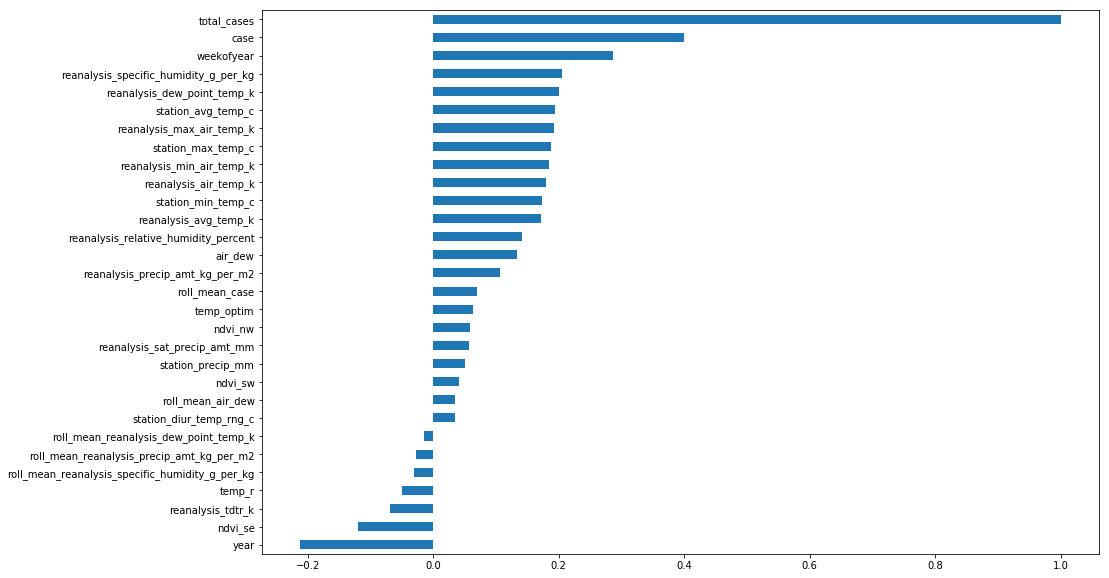

In [46]:
plt.figure(figsize=(15,10))
(sj_train_all.corr()
     .total_cases
     .sort_values(ascending=True)
     .plot
     .barh(color='C0'))

In [41]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel

In [33]:
regressor = ExtraTreesRegressor(n_estimators=250)
regressor.fit(sj_train_all.loc[:,sj_train_all.columns!='total_cases'], sj_train_all.total_cases)
print(regressor.feature_importances_)
sj_test_all.columns.values[regressor.feature_importances_ > 0.05].tolist()

[0.1468983  0.04465136 0.00775474 0.05651461 0.04634991 0.00791512
 0.00686976 0.01721609 0.01073458 0.00507722 0.00756379 0.00514213
 0.00372634 0.01913621 0.00671232 0.00764046 0.00454836 0.01460408
 0.00625705 0.00660602 0.00470648 0.00772478 0.00447125 0.13556297
 0.10535245 0.07531914 0.12333015 0.11161433]


['year',
 'ndvi_se',
 'case',
 'roll_mean_reanalysis_dew_point_temp_k',
 'roll_mean_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg',
 'roll_mean_air_dew']

In [26]:
regressor.fit(iq_train_all.loc[:,iq_train_all.columns != 'total_cases'], iq_train_all.total_cases)
print(regressor.feature_importances_)
iq_test_all.columns.values[regressor.feature_importances_ > 0.05]

[0.11080757 0.03843987 0.01960093 0.01767395 0.01407709 0.01804363
 0.01677118 0.01739637 0.02467277 0.02724256 0.02075796 0.0243409
 0.01904995 0.0159323  0.01810404 0.0550324  0.02949869 0.0302076
 0.01918873 0.01622895 0.04119928 0.01389892 0.01946783 0.18052766
 0.07644144 0.04678248 0.06861497]


array(['year', 'station_avg_temp_c', 'case',
       'roll_mean_reanalysis_dew_point_temp_k',
       'roll_mean_reanalysis_specific_humidity_g_per_kg'], dtype=object)

In [27]:
scaled_columns = test_numeric_columns + roll_columns
scaled_columns

['ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'temp_r',
 'temp_optim',
 'air_dew',
 'roll_mean_reanalysis_dew_point_temp_k',
 'roll_mean_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg']

In [28]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# sj_train_scaled = pd.DataFrame(scaler.fit_transform(sj_train_all[scaled_columns]))
# iq_train_scaled = pd.DataFrame(scaler.fit_transform(iq_train_all[scaled_columns]))
# # sj_train_scaled['year'] = sj_train_all.year.values
# # iq_train_scaled['year'] = iq_train_all.year.values
# sj_train_scaled['weekofyear'] = sj_train_all.weekofyear.values
# iq_train_scaled['weekofyear'] = iq_train_all.weekofyear.values
# sj_train_scaled['total_cases'] = sj_train_all.total_cases.values
# iq_train_scaled['total_cases'] = iq_train_all.total_cases.values

# sj_test_scaled = pd.DataFrame(scaler.fit_transform(sj_test_all[scaled_columns]))
# iq_test_scaled = pd.DataFrame(scaler.fit_transform(iq_test_all[scaled_columns]))
# # sj_test_scaled['year'] = sj_test_all.year.values
# # iq_test_scaled['year'] = iq_test_all.year.values
# sj_test_scaled['weekofyear'] = sj_test_all.weekofyear.values
# iq_test_scaled['weekofyear'] = iq_test_all.weekofyear.values

# sj_train_scaled.columns = scaled_columns + ['weekofyear', 'total_cases']
# iq_train_scaled.columns = scaled_columns + ['weekofyear', 'total_cases']

# sj_test_scaled.columns = scaled_columns + ['weekofyear']
# iq_test_scaled.columns = scaled_columns + ['weekofyear']

In [29]:
# adding new features to our data
sj_train_use = sj_train_all[['weekofyear', 'total_cases'] + climate_columns + roll_columns]
iq_train_use = iq_train_all[['weekofyear', 'total_cases'] + climate_columns + roll_columns]

sj_test_use = sj_test_all[['weekofyear'] + climate_columns + roll_columns]
iq_test_use = iq_test_all[['weekofyear'] + climate_columns + roll_columns]

In [30]:
# changes the outliers
def change_outliers(df, m):
    threshold = m * np.std(df.total_cases)
    lesser = (df.total_cases - np.mean(df.total_cases)) < threshold
    greater = (df.total_cases - np.mean(df.total_cases)) > threshold
    df.loc[greater, 'total_cases'] = threshold
    return df

# removes total cases outliers
def remove_outliers(df, m):
    return df[abs(df.total_cases - np.mean(df.total_cases)) < m * np.std(df.total_cases)]

# shows outliers
def show_outliers(df, m):
    threshold = m * np.std(df.total_cases)
    diff = abs(df.total_cases - np.mean(df.total_cases)) > threshold
    print(df[diff].head())

In [32]:
# sj_train = remove_outliers(sj_train_use, 2.5)
# iq_train = remove_outliers(iq_train_use, 2.5)
sj_cases = sj_train_use.total_cases
iq_cases = iq_train_use.total_cases
sj_train = sj_train_use.drop(columns=['total_cases'], axis=1)
iq_train = iq_train_use.drop(columns=['total_cases'], axis=1)

In [33]:
print(sj_cases.shape, sj_train.shape)
print(iq_cases.shape, iq_train.shape)

(936,) (936, 9)
(520,) (520, 9)


In [34]:
sj_train.columns.values.tolist()

['weekofyear',
 'reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'station_max_temp_c',
 'roll_mean_reanalysis_dew_point_temp_k',
 'roll_mean_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg']

In [35]:
from sklearn.model_selection import train_test_split

In [44]:
# splitting to subtrain and subtest for both cities to be used in cross validation
sj_train_X, sj_test_X, sj_train_y, sj_test_y = train_test_split(sj_train, 
                                                                sj_cases,
                                                                test_size = 0.2,
                                                                stratify=sj_train.weekofyear)
iq_train_X, iq_test_X, iq_train_y, iq_test_y = train_test_split(iq_train,
                                                                iq_cases,
                                                                test_size = 0.2,
                                                                stratify=iq_train.weekofyear)

In [45]:
sj_train.columns.values.tolist()

['weekofyear',
 'reanalysis_dew_point_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'station_max_temp_c',
 'roll_mean_reanalysis_dew_point_temp_k',
 'roll_mean_reanalysis_precip_amt_kg_per_m2',
 'roll_mean_reanalysis_specific_humidity_g_per_kg']

In [46]:
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import Booster

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [47]:
# defining the regressors
xgb_regressor = XGBRegressor(random_state=777)
rf_regressor = RandomForestRegressor(random_state=777)
gb_regressor = GradientBoostingRegressor(random_state=777)
sv_regressor = SVR()

### Baseline Models

In [48]:
# XGB baseline models
sj_xgb_bm = xgb_regressor.fit(sj_train_X, sj_train_y)
iq_xgb_bm = xgb_regressor.fit(iq_train_X, iq_train_y)

sj_xgb_bm_y = sj_xgb_bm.predict(sj_test_X)
iq_xgb_bm_y = iq_xgb_bm.predict(iq_test_X)

print('SJ XGBoost baseline MAE:', mean_absolute_error(sj_xgb_bm_y, sj_test_y))
print('IQ XGBoost baseline MAE:', mean_absolute_error(iq_xgb_bm_y, iq_test_y))

SJ XGBoost baseline MAE: 32.88141034622776
IQ XGBoost baseline MAE: 4.211417745798826


In [49]:
# Random Forest baseline models
sj_rf_bm = rf_regressor.fit(sj_train_X, sj_train_y)
iq_rf_bm = rf_regressor.fit(iq_train_X, iq_train_y)

sj_rf_bm_y = sj_rf_bm.predict(sj_test_X)
iq_rf_bm_y = iq_rf_bm.predict(iq_test_X)

print('SJ Random Forest baseline MAE:', mean_absolute_error(sj_rf_bm_y, sj_test_y))
print('IQ Random Forest baseline MAE:', mean_absolute_error(iq_rf_bm_y, iq_test_y))

SJ Random Forest baseline MAE: 30.696276595744685
IQ Random Forest baseline MAE: 3.844230769230769


In [50]:
# Gradient Boost baseline models
sj_gb_bm = gb_regressor.fit(sj_train_X, sj_train_y)
iq_gb_bm = gb_regressor.fit(iq_train_X, iq_train_y)

sj_gb_bm_y = sj_gb_bm.predict(sj_test_X)
iq_gb_bm_y = iq_gb_bm.predict(iq_test_X)

print('SJ Gradient Boost baseline MAE:', mean_absolute_error(sj_gb_bm_y, sj_test_y))
print('IQ Gradient Boost baseline MAE:', mean_absolute_error(iq_gb_bm_y, iq_test_y))

SJ Gradient Boost baseline MAE: 32.75163098819096
IQ Gradient Boost baseline MAE: 4.227434131750952


In [51]:
# Support Vector baseline models
sj_sv_bm = sv_regressor.fit(sj_train_X, sj_train_y)
iq_sv_bm = sv_regressor.fit(iq_train_X, iq_train_y)

sj_sv_bm_y = sj_sv_bm.predict(sj_test_X)
iq_sv_bm_y = iq_sv_bm.predict(iq_test_X)

print('SJ Support Vector baseline MAE:', mean_absolute_error(sj_sv_bm_y, sj_test_y))
print('IQ Support Vector baseline MAE:', mean_absolute_error(iq_sv_bm_y, iq_test_y))

SJ Support Vector baseline MAE: 31.44266884794114
IQ Support Vector baseline MAE: 4.842875586626515


## GridSearch

In [52]:
# returns model
def get_model(X, y, estimator, param_grid):            
    
    grid_search = GridSearchCV(estimator=estimator, 
                               param_grid=param_grid, 
                               scoring="neg_mean_absolute_error", 
                               cv=KFold(n_splits=10, shuffle=True, random_state=1))
    
    grid_result = grid_search.fit(X=X, y=y)
    print(grid_result.best_score_)
    print(grid_result.best_params_)
    return grid_result

In [53]:
# saves the submission into csv
def save_formatted_csv(sj_preds, iq_preds, filename):
    submission = pd.read_csv("data/submission_format.csv",
                             index_col=[0, 1, 2])
    submission.total_cases = np.concatenate([sj_preds, iq_preds])
    submission.to_csv("data/" + filename + ".csv")

In [54]:
# defining parameters for gridsearch
xgb_params = {'n_estimators': [100, 200, 500], 
              'max_depth': [3, 5],
              'learning_rate': [0.01, 0.1, 0.2],
              'gamma': [0.1, 0.2]}
rf_params = {'n_estimators': [250]}
gb_params = {'n_estimators': [100, 200, 250], 
             'max_depth': range(5,7),
             'learning_rate': [0.01, 0.1, 0.2]}
sv_params = {'kernel':['linear'],
             'C':[0.1, 1],
             'gamma':[ 0.01, 0.1, 1]}

### XGBoost Model

In [135]:
# # grid search on sj xgb model
# sj_xgb_model = get_model(sj_train_X, sj_train_y, xgb_regressor, xgb_params)

In [136]:
# # grid search to get model
# iq_xgb_model = get_model(iq_train_X, iq_train_y, xgb_regressor, xgb_params)

In [137]:
# # checking mae values
# sj_xgb_y = sj_gb_model.predict(sj_test_X)
# iq_xgb_y = iq_xgb_model.predict(iq_test_X)
# sj_gb_y = sj_gb_y.clip(min=0)
# iq_xgb_y = iq_xgb_y.clip(min=0)

# print('SJ XGB baseline MAE:', mean_absolute_error(sj_xgb_y, sj_test_y))
# print('IQ XGB baseline MAE:', mean_absolute_error(iq_xgb_y, iq_test_y))

In [138]:
# sj_xgb_preds = sj_xgb_model.predict(sj_test_use).astype(int)
# iq_xgb_preds = iq_xgb_model.predict(iq_test_use).astype(int)
# sj_xgb_preds = sj_xgb_preds.clip(min=0)
# iq_xgb_preds = iq_xgb_preds.clip(min=0)

In [139]:
# sns.scatterplot(data=np.concatenate((sj_xgb_preds, iq_xgb_preds), axis=0))

In [140]:
# save_formatted_csv(sj_xgb_preds, iq_xgb_preds, 'xgb_preds_new')

<a id="rf"></a>
[col](#col)
### Random Forest Model

In [55]:
# grid search on sj xgb model
sj_rf_model = get_model(sj_train_X, sj_train_y, rf_regressor, rf_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-13.239256684491979
{'n_estimators': 250}


In [56]:
# grid search on iq xgb model
iq_rf_model = get_model(iq_train_X, iq_train_y, rf_regressor, rf_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-5.185317307692308
{'n_estimators': 250}


In [57]:
# testing mae
sj_rf_y = sj_rf_model.predict(sj_test_X)
iq_rf_y = iq_rf_model.predict(iq_test_X)
sj_rf_y = sj_rf_y.clip(min=0)
iq_rf_y = iq_rf_y.clip(min=0)

print('SJ Random Forest baseline MAE:', mean_absolute_error(sj_rf_y, sj_test_y))
print('IQ Random Forest baseline MAE:', mean_absolute_error(iq_rf_y, iq_test_y))

SJ Random Forest baseline MAE: 12.035446808510637
IQ Random Forest baseline MAE: 3.9367692307692304


In [58]:
sj_rf_preds = sj_rf_model.predict(sj_test_use).round().astype(int)
iq_rf_preds = iq_rf_model.predict(iq_test_use).round().astype(int)
sj_rf_preds = sj_rf_preds.clip(min=0)
iq_rf_preds = iq_rf_preds.clip(min=0)

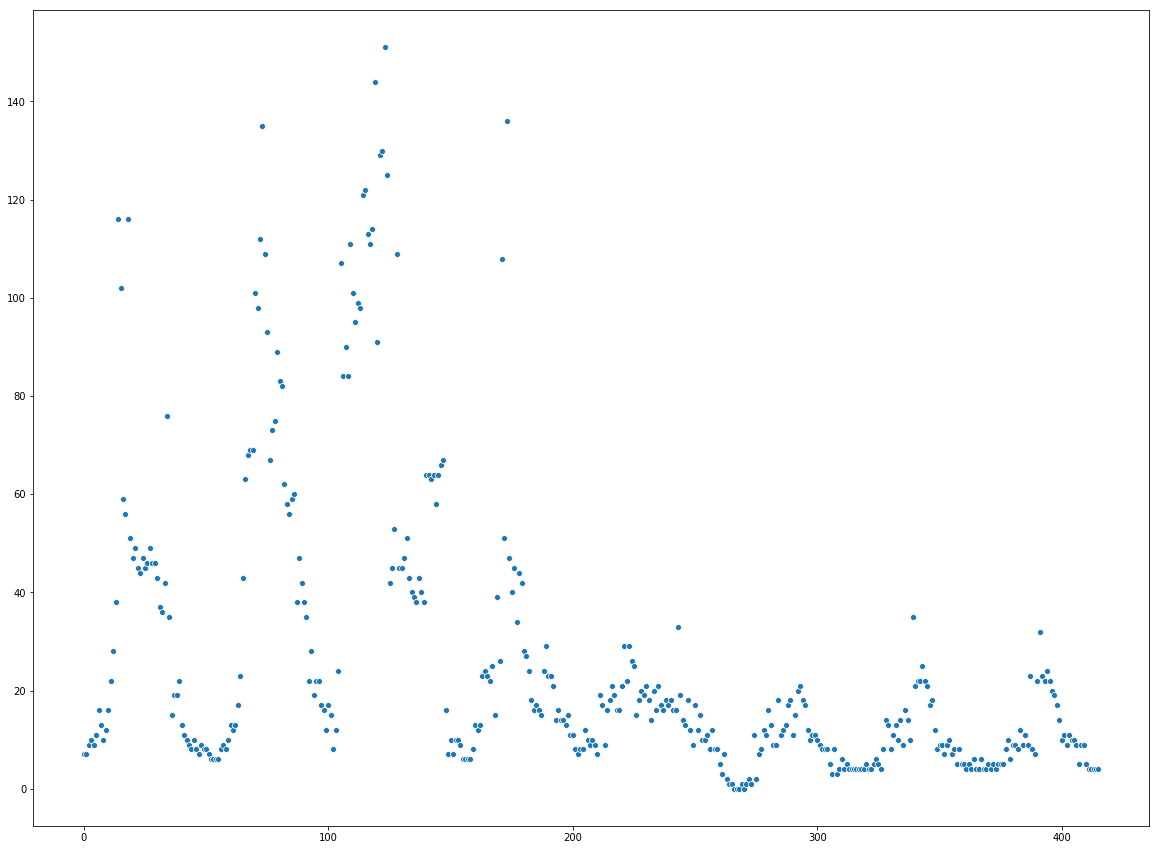

In [59]:
plt.figure(figsize=(20,15))
results = np.concatenate((sj_rf_preds, iq_rf_preds),axis=0)
sns.scatterplot(data=results)


In [67]:
save_formatted_csv(sj_rf_preds, iq_rf_preds, 'rf_preds_two')
pd.read_csv

### Gradient Boost Model

In [61]:
# grid search on sj xgb model
sj_gb_model = get_model(sj_train_X, sj_train_y, gb_regressor, gb_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-13.44516230308522
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [62]:
# grid search on iq xgb model
iq_gb_model = get_model(iq_train_X, iq_train_y, gb_regressor, gb_params)

-4.794466951548227
{'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
# testing mae
sj_gb_y = sj_gb_model.predict(sj_test_X)
iq_gb_y = iq_gb_model.predict(iq_test_X)
sj_gb_y = sj_gb_y.clip(min=0)
iq_gb_y = iq_gb_y.clip(min=0)

print('SJ Gradient Boost baseline MAE:', mean_absolute_error(sj_gb_y, sj_test_y))
print('IQ Gradient Boost baseline MAE:', mean_absolute_error(iq_gb_y, iq_test_y))

SJ Gradient Boost baseline MAE: 11.95123665199686
IQ Gradient Boost baseline MAE: 3.5498374956501872


In [64]:
sj_gb_preds = sj_gb_model.predict(sj_test_use).round().astype(int)
iq_gb_preds = iq_gb_model.predict(iq_test_use).round().astype(int)
sj_gb_preds = sj_gb_preds.clip(min=0)
iq_gb_preds = iq_gb_preds.clip(min=0)

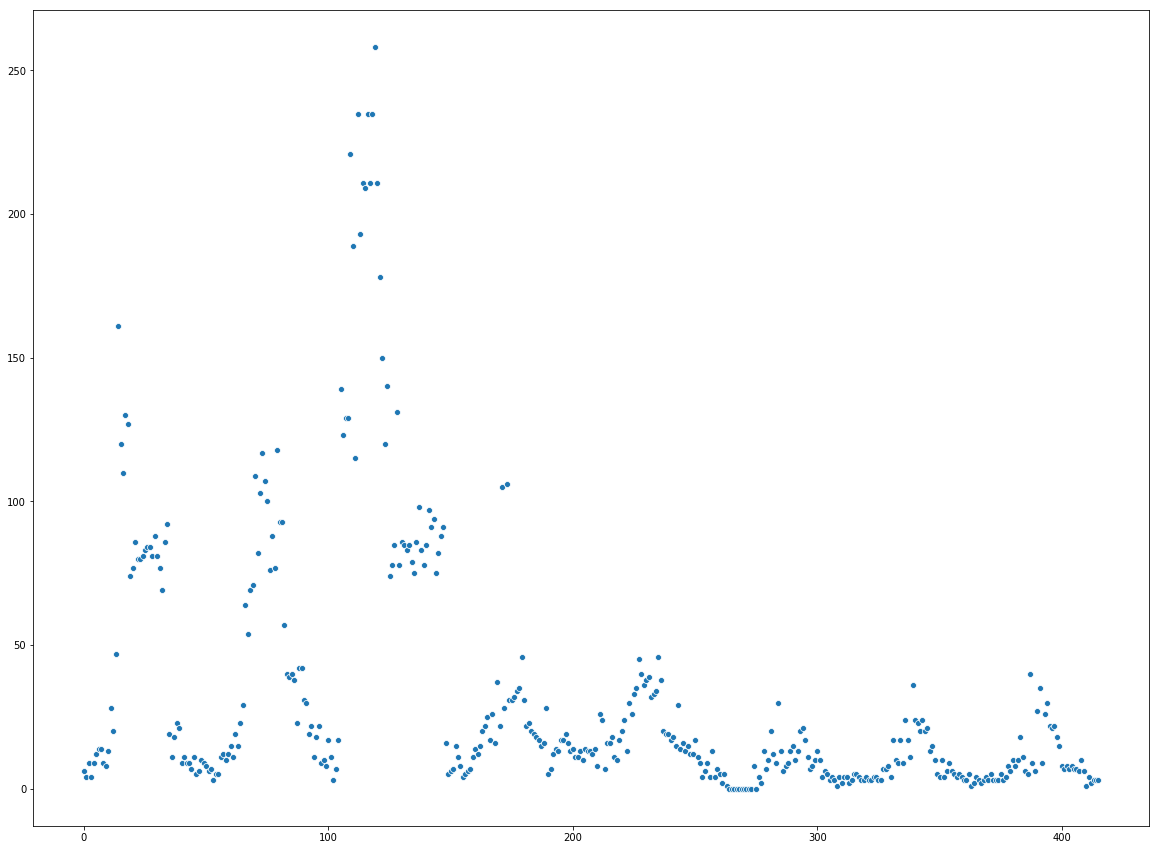

In [65]:
plt.figure(figsize=(20,15))
# rf = pd.read_csv("data/22_rf_preds_new.csv").total_cases
# gb = pd.read_csv("data/23_gb_preds2.csv").total_cases
# sns.scatterplot(data=rf)
# sns.scatterplot(data=gb)
sns.scatterplot(data=np.concatenate((sj_gb_preds, iq_gb_preds), axis=0))

In [66]:
save_formatted_csv(sj_gb_preds, iq_rf_preds, 'gb_preds')

### SVM Model

In [87]:
# grid search on sj xgb model
sj_sv_model = get_model(sj_train_X, sj_train_y, sv_regressor, sv_params)

-16.654611334252014
{'C': 1, 'gamma': 0.01, 'kernel': 'linear'}


In [88]:
# grid search on iq xgb model
iq_sv_model = get_model(iq_train_X, iq_train_y, sv_regressor, sv_params)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-4.325309654239889
{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}


In [89]:
sj_sv_y = sj_sv_model.predict(sj_test_X)
iq_sv_y = iq_sv_model.predict(iq_test_X)
sj_sv_y = sj_sv_y.clip(min=0)
iq_sv_y = iq_sv_y.clip(min=0)

print('SJ SVM baseline MAE:', mean_absolute_error(sj_sv_y, sj_test_y))
print('IQ SVM baseline MAE:', mean_absolute_error(iq_sv_y, iq_test_y))

SJ SVM baseline MAE: 14.016263411051009
IQ SVM baseline MAE: 4.504091248394759


In [90]:
sj_sv_preds = sj_sv_model.predict(sj_test_use).astype(int)
iq_sv_preds = iq_sv_model.predict(iq_test_use).astype(int)
sj_sv_preds = sj_sv_preds.clip(min=0)
iq_sv_preds = iq_sv_preds.clip(min=0)

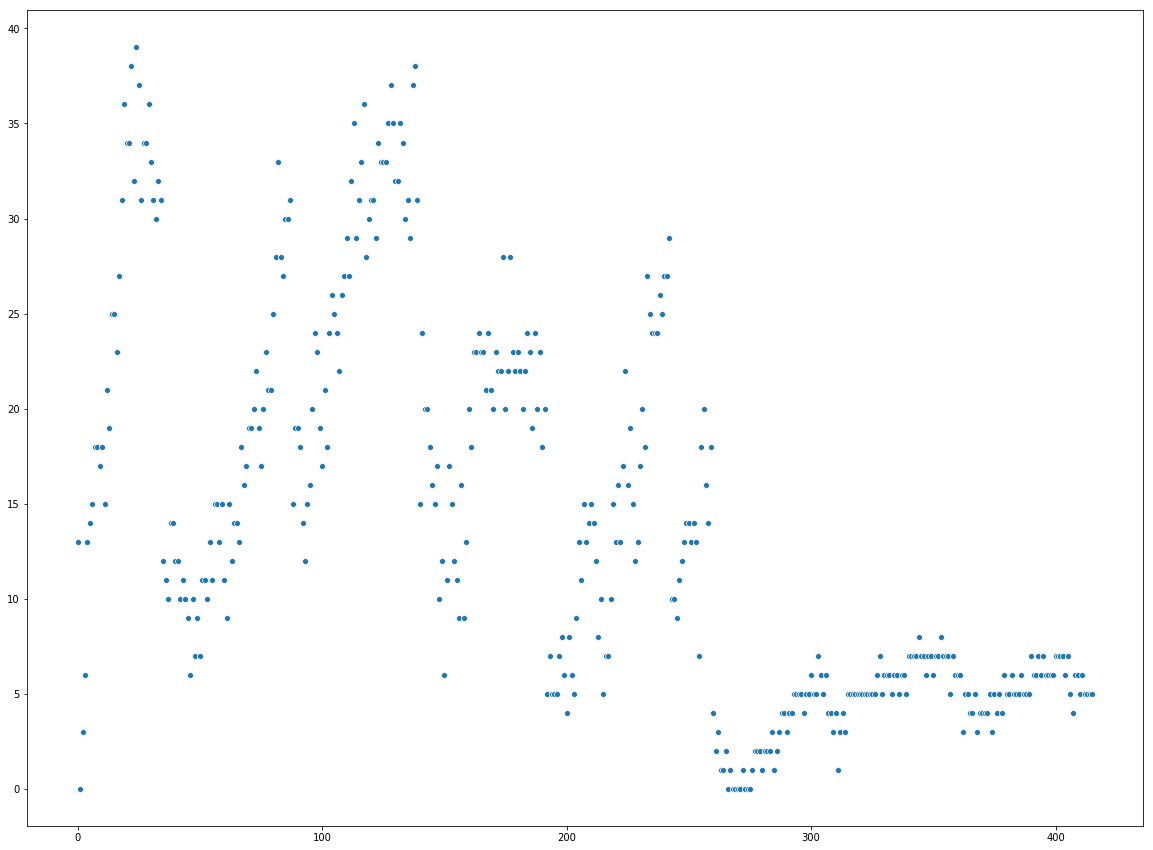

In [91]:
plt.figure(figsize=(20,15))
sns.scatterplot(data=np.concatenate((sj_sv_preds, iq_sv_preds), axis=0))

In [1322]:
# save_formatted_csv(sj_sv_preds, iq_sv_preds, 'sv_preds_new')

### Test Predictions

In [ ]:
# # plots time series of predicted vs actual cases
# def plot_preds_actual_time(train_cases, test_cases, actual_cases):
#     total = pd.DataFrame()
#     total['pred_cases'] = train_cases + test_cases
# #     total['actual_cases'] = actual_cases
    
#     # plotting time forecast of predicted cases vs actual cases
#     plt.figure(figsize=(20, 10))
#     total.pred_cases.plot(label="Predictions", color='C0')
#     actual_cases.plot(label="Actual", color='C3')

#     plt.ylabel('dengue count')
#     plt.title("Dengue Predicted Cases vs. Actual Cases", fontsize=20)
#     plt.legend(fontsize=20)